<a href="https://colab.research.google.com/github/niwanshu16/FDSP2019/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.getcwd()
os.chdir('/content/drive/My Drive/DeepLearning')


In [0]:
from keras.datasets import mnist

In [0]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
(train_X , train_y) , (test_X,test_y) = mnist.load_data()
print("Train {} , {}".format(train_X.shape , train_y.shape))
print("Test {} , {}".format(test_X.shape , test_y.shape))

11493376/11490434 [==============================] - 1s 0us/step
Train (60000, 28, 28) , (60000,)
Test (10000, 28, 28) , (10000,)


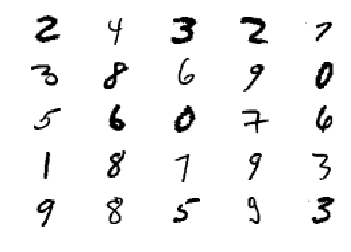

In [0]:
j=0
for i in range(25 , 50):
  pyplot.subplot(5,5,j+1)
  pyplot.axis('off')
  pyplot.imshow(train_X[i] , cmap = 'gray_r')
  j+=1
pyplot.show()

In [0]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense , Conv2D , Flatten , Dropout , LeakyReLU
from keras.utils.vis_utils import plot_model

In [0]:
# Define and train the discriminator model

def define_discriminator(in_shape = (28,28,1)):
  model = Sequential()
  model.add(Conv2D(64,(3,3) , strides = (2,2) , padding = 'same' , input_shape = in_shape))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0,4))
  model.add(Conv2D(64,(3,3) , strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0,4))
  model.add(Flatten())
  model.add(Dense(1 , activation = 'sigmoid'))
  
  # Compile 
  opt = Adam(lr = 0.0002 , beta_1 = 0.9)
  model.compile(loss = 'binary_crossentropy' , optimizer = opt , metrics = ['accuracy'])
  return model

model = define_discriminator()
model.summary()
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)
  

  

W0724 06:58:11.360113 139900125681536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0724 06:58:11.373433 139900125681536 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [0]:
def load_real_samples():
  (train_X , _) , (_,_) = mnist.load_data()
  X = train_X.reshape(train_X.shape[0] , 28 , 28 , 1)
  X = X.astype(np.float32)
  X = X/255.0
  return X

In [0]:
# Generate the  random subsamples from dataset
def generate_real_samples(dataset , n_samples):
  # Choose random instances
  ix = np.random.randint(0 , dataset.shape[0] , n_samples)
  X = dataset[ix]
  y = np.ones((n_samples , 1 )) # Generate n_samples real ones to indicate real images
  return X,y


In [0]:
# This function generate n samples of fake images
def generate_fake_samples(n_samples):
  X = np.random.randn(28*28*n_samples)
  X = X.reshape(n_samples , 28 , 28, 1)
  y = np.zeros((n_samples , 1))
  return X , y  


In [0]:
# Train the discriminator model
def train_discriminator_model(model , dataset , n_iter = 100 , batch_size = 256):
  half_batch = int(batch_size/2)
  for i in range(n_iter):
    X_real , y_real = generate_real_samples(dataset , half_batch) # Generate real images with label 1
    _ , real_acc = model.train_on_batch(X_real , y_real)
    
    X_fake , y_fake = generate_fake_samples(half_batch) # Generate fake images
    _ , fake_acc = model.train_on_batch(X_fake , y_fake)
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
    


In [0]:
model = define_discriminator()
dataset = load_real_samples()


In [0]:
train_discriminator_model(model , dataset)

In [0]:
# Generator model 
'''
This model is responsible for generating the new fake images to fake classifier or discriminator
'''
from keras.models import Sequential
from keras.layers import Conv2D , Conv2DTranspose , Reshape , Dense , LeakyReLU
from keras.utils.vis_utils import plot_model

In [0]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
def generate_latent_points(latent_dim , n_samples):
  x_input = np.random.rand(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples , latent_dim)
  return x_input

In [0]:
def generate_fake_samples(g_model , latent_dim , n_samples):
  x_input = generate_latent_points(latent_dim , n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples , 1))
  return X,y

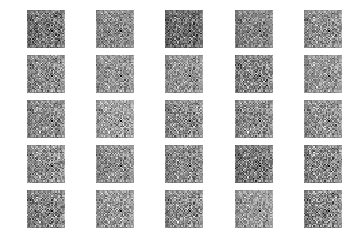

In [0]:
n_samples = 25
X , _ = generate_fake_samples(model , latent_dim , n_samples)
for i in range(n_samples):
  pyplot.subplot(5,5,1+i)
  pyplot.axis('off')
  pyplot.imshow(X[i ,:, :,0] , cmap='gray_r')
pyplot.show()

In [0]:
# GAN model
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [0]:
#This images are like this because the generator model is not trained
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)


In [0]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
  pyplot.show()
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [0]:
def train(g_model , d_model , gan_model , dataset , latent_dim , n_epochs = 100 , n_batch = 256):
  batch_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(batch_per_epo):
      X_real , y_real = generate_real_samples(dataset , half_batch)
      X_fake , y_fake = generate_fake_samples(g_model , latent_dim , half_batch)
      X , y = np.vstack((X_real , X_fake)) , np.vstack((y_real , y_fake))
      # Update discriminator weights 
      d_loss , _ = d_model.train_on_batch(X,y)
      X_gan = generate_latent_points(latent_dim , n_batch)
      y_gan = np.ones((n_batch , 1))
      g_loss = gan_model.train_on_batch(X_gan , y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epo, d_loss, g_loss))
    if (i+1)%10==0:
      summarize_performance(i, g_model , d_model , dataset , latent_dim)
  
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [0]:
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/234, d=0.712, g=0.674
>1, 2/234, d=0.701, g=0.690


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 3/234, d=0.692, g=0.716
>1, 4/234, d=0.683, g=0.731
>1, 5/234, d=0.676, g=0.748
>1, 6/234, d=0.673, g=0.772
>1, 7/234, d=0.659, g=0.793
>1, 8/234, d=0.653, g=0.809
>1, 9/234, d=0.650, g=0.824
>1, 10/234, d=0.644, g=0.831
>1, 11/234, d=0.645, g=0.834
>1, 12/234, d=0.641, g=0.832
>1, 13/234, d=0.638, g=0.815
>1, 14/234, d=0.643, g=0.795
>1, 15/234, d=0.650, g=0.772
>1, 16/234, d=0.651, g=0.751
>1, 17/234, d=0.647, g=0.735
>1, 18/234, d=0.648, g=0.723
>1, 19/234, d=0.642, g=0.715
>1, 20/234, d=0.635, g=0.708
>1, 21/234, d=0.632, g=0.704
>1, 22/234, d=0.622, g=0.702
>1, 23/234, d=0.617, g=0.700
>1, 24/234, d=0.607, g=0.699
>1, 25/234, d=0.596, g=0.699
>1, 26/234, d=0.592, g=0.698
>1, 27/234, d=0.585, g=0.698
>1, 28/234, d=0.575, g=0.698
>1, 29/234, d=0.562, g=0.698
>1, 30/234, d=0.552, g=0.699
>1, 31/234, d=0.543, g=0.699
>1, 32/234, d=0.532, g=0.700
>1, 33/234, d=0.528, g=0.701
>1, 34/234, d=0.517, g=0.701
>1, 35/234, d=0.502, g=0.702
>1, 36/234, d=0.499, g=0.703
>1, 37/234, d=0.489, 